tensorboard --logdir=runs

In [1]:
import os
from matplotlib import pyplot as plt
import time
import numpy as np
import pandas as pd
import math
import glob
import random

import torchaudio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchaudio.functional as torchaudio_F
import torchaudio.transforms as torchaudio_T
import tqdm

from src.dataset_v2 import LibriSpeech_Dataset, padding_tensor
from src.model import CPC, infoNCEloss, cyclical_lr


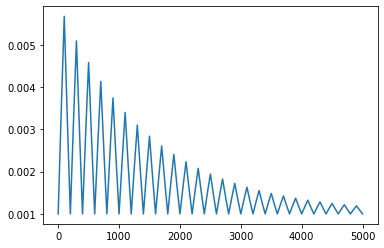

In [2]:
clr = cyclical_lr(100, min_lr=0.001, gap_lr=0.005, exp_decay=1.5e3)
x = np.arange(0,5000)
lr = list(map(lambda x: clr(x), x))
plt.plot(x, lr)

# Training

In [2]:
batch_size = 16

model = CPC(decoder_heads=12)
model.load_state_dict(torch.load('./libri-34106-fw3-h12-ep8.pth'))
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

base_path = os.path.join(os.path.expanduser('~'), 'Jupyter-data/LibriSpeech/')
dataset = LibriSpeech_Dataset(base_path, test=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=padding_tensor)

print(dataset.__len__())

182794


In [3]:
loss_vec = []
n_ts_sample = 150
n_neg_sample = 16
fwd_factor = 3
look_fwd_idx = np.arange(1,1+model.decoder_heads)*fwd_factor
n_sample_per_epoch = dataloader.__len__()

writer = SummaryWriter(flush_secs=60)
cnt_step = 0

In [ ]:
model.train()

for ep in range(1,30):
    for x in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        
        phi_n, c_n = model(x.to('cuda'))
        ts_length = phi_n.shape[2]
        decoder_heads = model.decoder_heads

        loss = torch.tensor(0.0).to('cuda')
        t_sample = np.random.randint(0,ts_length-decoder_heads*fwd_factor,n_ts_sample)

        for t in t_sample:
            c_t = c_n[:,t]
            phi_hat = model.decoder(c_t)

            query = phi_hat.permute(2,0,1).flatten(start_dim=0, end_dim=1)
            positive_key = phi_n[:,:,t+look_fwd_idx].permute(2,0,1).flatten(start_dim=0, end_dim=1)

            idx_batch = torch.randint(0, x.shape[0], (n_neg_sample,)) # Don't use batch_size, due to last batch is not 16
            idx_ts = torch.randint(0, ts_length, (n_neg_sample,))
            negative_keys = phi_n[idx_batch,:,idx_ts]

            loss += infoNCEloss(query, positive_key, negative_keys)/(n_ts_sample)

        loss.backward()
        optimizer.step()
        # scheduler.step()
        
        cnt_step += 1
        writer.add_scalar('Loss/train', loss, cnt_step)

In [5]:
torch.save(model.state_dict(), './libri-182794-fw3-h12-ep'+str(ep)+'.pth')